# Uncertainty for unseen categories in deep learning

We investigate uncertainty in deep learning prediction. In particular, we are interested in how confident a neural network classifier is in making predictions for a category it has not seen in training, and therefore will not classify correctly. To this end, we utilise Bayesian neural networks using Monte Carlo (MC) dropout and variational inference (VI) on the Fashion MNIST.

In [1]:
# Imports

import tensorflow as tf
from tensorflow import keras
import tensorflow_probability as tfp

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('default')

print(f"TensorFlow version: {tf.__version__}")
print(f"TensorFlow Probability version {tfp.__version__}")

TensorFlow version: 2.8.0
TensorFlow Probability version 0.16.0


In [25]:
tfp.__version__

'0.16.0'

In [2]:
# Load Fashion MNIST dataset
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()

In [3]:
print(X_train_full.shape)
print(y_train_full.shape)

(60000, 28, 28)
(60000,)


In [4]:
print(X_test.shape)
print(y_test.shape)

(10000, 28, 28)
(10000,)


In [7]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

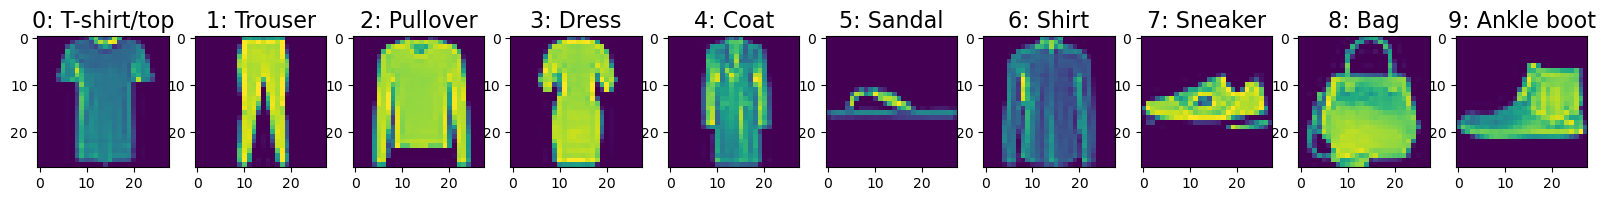

In [8]:
np.random.seed(22)
plt.figure(figsize=(20,20))
for i in range(0,len(np.unique(y_train_full))):
    rand=np.random.choice(np.where(y_train_full==i)[0],1)
    plt.subplot(1,10,i+1)
    img=X_train_full[rand]
    plt.imshow(img[0,:,:,])
    plt.title(str(y_train_full[rand][0])+ ": " +class_names[i],fontsize=16)

In [9]:
# Let's remove one class and make it "unknown"
from copy import deepcopy
unknown_class = 1 # Let's remove 'Trousers'
y_train_known = np.delete(y_train_full,np.where(y_train_full==unknown_class)[0])
X_train_known = np.delete(X_train_full,np.where(y_train_full==unknown_class)[0],axis=0)
class_names_known = deepcopy(class_names)
del class_names_known[unknown_class]
print(y_train_known.shape)
print(X_train_known.shape)
print(class_names)
print(class_names_known)

(54000,)
(54000, 28, 28)
['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
['T-shirt/top', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']


In [10]:
# Create train and validation sets from "known" training sets
from sklearn.model_selection import train_test_split
X_train, X_valid, y_train, y_valid = train_test_split(X_train_known, y_train_known, test_size=0.3, random_state=42)

In [11]:
# Normalize features
X_train, X_valid = ( (X_train/255.) -0.5 )*2, ( (X_valid/255.) -0.5 )*2.

In [12]:
# One-hot encode response
y_train_onehot = np.array(pd.get_dummies(y_train))
y_valid_onehot = np.array(pd.get_dummies(y_valid))

In [13]:
pd.Series(y_train).nunique()

9

In [14]:
y_train_onehot.shape

(37800, 9)

# MC Dropout

In [15]:
from tensorflow.keras.layers import Convolution2D, MaxPooling2D, Dropout, Flatten, Dense, Input, BatchNormalization
from tensorflow.keras import Model

# Create a separate class for MCDropout layers that can be used also during test
class MCDropout(Dropout):
    def call(self, inputs):
        return super().call(inputs, training=True)

BATCH_SIZE = 32    
    
# Define model
input_ = Input(shape=(28,28,1))
x = Convolution2D(8,kernel_size=(3,3),padding="same", activation = 'selu')(input_)
x = MCDropout((0.3))(x)
x = Convolution2D(16,kernel_size=(3,3),padding="same", activation = 'selu')(x)
x = MCDropout((0.3))(x)
x = MaxPooling2D((2,2))(x)
x = Convolution2D(32,kernel_size=(3,3),padding="same", activation = 'selu')(x)
x = MCDropout((0.3))(x)
x = MaxPooling2D((2,2))(x)
x = Convolution2D(64,kernel_size=(3,3),padding="same", activation = 'selu')(x)
x = MCDropout((0.3))(x)
x = MaxPooling2D((2,2))(x)
x = Convolution2D(128,kernel_size=(3,3),padding="same", activation = 'selu')(x)
x = MCDropout((0.3))(x)
x = MaxPooling2D((2,2))(x)
x = Flatten()(x)
x = Dense(100, activation = 'selu')(x)
x = BatchNormalization()(x)
x = MCDropout((0.3))(x)
x = Dense(100, activation = 'selu')(x)
x = BatchNormalization()(x)
x = MCDropout((0.3))(x)
x = Dense(9, activation = 'softmax')(x)
model_mc = Model(inputs=[input_], outputs=[x])

model_mc.compile(loss='categorical_crossentropy', optimizer="adam", metrics=['accuracy'])

model_mc.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 28, 28, 8)         80        
                                                                 
 mc_dropout (MCDropout)      (None, 28, 28, 8)         0         
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 16)        1168      
                                                                 
 mc_dropout_1 (MCDropout)    (None, 28, 28, 16)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 16)       0         
 )                                                               
                                                             

In [17]:
history_mc=model_mc.fit(X_train, y_train_onehot,
                        validation_data=(X_valid, y_valid_onehot),
                        batch_size=BATCH_SIZE,
                        epochs=500,
                        verbose=1,
                        callbacks=[keras.callbacks.EarlyStopping(patience=10), keras.callbacks.ModelCheckpoint("mc_dropout_model_no_trousers.h5", save_best_only=True)])

Epoch 1/500
1182/1182 [==============================] - 32s 26ms/step - loss: 0.8186 - accuracy: 0.6989 - val_loss: 0.5832 - val_accuracy: 0.7849
Epoch 2/500
1182/1182 [==============================] - 65s 55ms/step - loss: 0.5348 - accuracy: 0.8093 - val_loss: 0.4869 - val_accuracy: 0.8261
Epoch 3/500
1182/1182 [==============================] - 45s 38ms/step - loss: 0.4674 - accuracy: 0.8322 - val_loss: 0.4272 - val_accuracy: 0.8431
Epoch 4/500
1182/1182 [==============================] - 40s 34ms/step - loss: 0.4258 - accuracy: 0.8463 - val_loss: 0.3983 - val_accuracy: 0.8586
Epoch 5/500
1182/1182 [==============================] - 41s 35ms/step - loss: 0.4010 - accuracy: 0.8564 - val_loss: 0.3993 - val_accuracy: 0.8553
Epoch 6/500
1182/1182 [==============================] - 45s 38ms/step - loss: 0.3795 - accuracy: 0.8649 - val_loss: 0.3794 - val_accuracy: 0.8630
Epoch 7/500
1182/1182 [==============================] - 43s 36ms/step - loss: 0.3665 - accuracy: 0.8700 - val_loss: 0

In [18]:
df_hist = pd.DataFrame(history_mc.history)

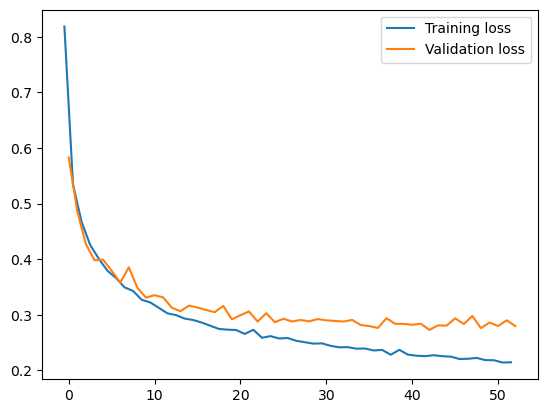

In [19]:
plt.plot(np.arange(len(df_hist.loss))-0.5, df_hist.loss, label="Training loss")
plt.plot(np.arange(len(df_hist.loss)), df_hist.val_loss, label="Validation loss")
plt.legend()

# Bayesian neural network

In [33]:
from tensorflow.keras.layers import Convolution2D, MaxPooling2D, Dropout, Flatten, Dense, Input, BatchNormalization
from tensorflow.keras import Model


kernel_divergence_fn=lambda q, p, _: tfp.distributions.kl_divergence(q, p) / (X_train.shape[0] *1.0)

# Define model
input_ = Input(shape=(28,28,1))
x = tfp.layers.Convolution2DFlipout(8,kernel_size=(3,3),padding="same", activation = 'selu', kernel_divergence_fn=kernel_divergence_fn)(input_)
x = tfp.layers.Convolution2DFlipout(16,kernel_size=(3,3),padding="same", activation = 'selu', kernel_divergence_fn=kernel_divergence_fn)(x)
x = MaxPooling2D((2,2))(x)
x = tfp.layers.Convolution2DFlipout(32,kernel_size=(3,3),padding="same", activation = 'selu', kernel_divergence_fn=kernel_divergence_fn)(x)
x = MaxPooling2D((2,2))(x)
x = tfp.layers.Convolution2DFlipout(64,kernel_size=(3,3),padding="same", activation = 'selu', kernel_divergence_fn=kernel_divergence_fn)(x)
x = MaxPooling2D((2,2))(x)
x = tfp.layers.Convolution2DFlipout(128,kernel_size=(3,3),padding="same", activation = 'selu', kernel_divergence_fn=kernel_divergence_fn)(x)
x = MaxPooling2D((2,2))(x)
x = Flatten()(x)
x = tfp.layers.DenseFlipout(100, activation = 'selu', kernel_divergence_fn=kernel_divergence_fn)(x)
x = BatchNormalization()(x)
x = tfp.layers.DenseFlipout(100, activation = 'selu', kernel_divergence_fn=kernel_divergence_fn)(x)
x = BatchNormalization()(x)
x = tfp.layers.DenseFlipout(9, activation = 'softmax', kernel_divergence_fn=kernel_divergence_fn)(x)
model_vi = Model(inputs=[input_], outputs=[x])

model_vi.compile(loss='categorical_crossentropy', optimizer="adam", metrics=['accuracy'])

model_vi.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_flipout_15 (Conv2DFl  (None, 28, 28, 8)        152       
 ipout)                                                          
                                                                 
 conv2d_flipout_16 (Conv2DFl  (None, 28, 28, 16)       2320      
 ipout)                                                          
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 14, 14, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_flipout_17 (Conv2DFl  (None, 14, 14, 32)       9248      
 ipout)                                                    

In [35]:
history_vi=model_vi.fit(X_train, y_train_onehot,
                        validation_data=(X_valid, y_valid_onehot),
                        batch_size=BATCH_SIZE,
                        epochs=200,
                        verbose=1,
                        callbacks=[keras.callbacks.EarlyStopping(patience=10), keras.callbacks.ModelCheckpoint("vi_dropout_model_no_trousers.h5", save_best_only=True)])

Epoch 1/1000
1182/1182 [==============================] - 61s 51ms/step - loss: 8.2261 - accuracy: 0.7906 - val_loss: 7.8346 - val_accuracy: 0.8327
Epoch 2/1000
1182/1182 [==============================] - 61s 51ms/step - loss: 7.5232 - accuracy: 0.8360 - val_loss: 7.1696 - val_accuracy: 0.8535
Epoch 3/1000
1182/1182 [==============================] - 73s 62ms/step - loss: 6.8507 - accuracy: 0.8558 - val_loss: 6.5270 - val_accuracy: 0.8575
Epoch 4/1000
1182/1182 [==============================] - 62s 53ms/step - loss: 6.2304 - accuracy: 0.8609 - val_loss: 5.9307 - val_accuracy: 0.8677
Epoch 5/1000
1182/1182 [==============================] - 65s 55ms/step - loss: 5.6614 - accuracy: 0.8688 - val_loss: 5.3953 - val_accuracy: 0.8714
Epoch 6/1000
1182/1182 [==============================] - 61s 52ms/step - loss: 5.1495 - accuracy: 0.8756 - val_loss: 4.9156 - val_accuracy: 0.8762
Epoch 7/1000
1182/1182 [==============================] - 60s 51ms/step - loss: 4.6965 - accuracy: 0.8776 - val_

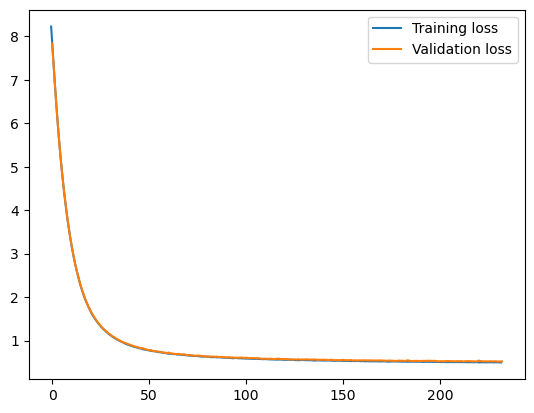

In [91]:
df_hist_vi = pd.DataFrame(history_vi.history)
plt.plot(np.arange(len(df_hist_vi.loss))-0.5, df_hist_vi.loss, label="Training loss")
plt.plot(np.arange(len(df_hist_vi.loss)), df_hist_vi.val_loss, label="Validation loss")
plt.legend()

In [77]:
X_test=((X_test/255)-0.5)*2

In [78]:
known_idx=np.where(y_test != unknown_class)[0]
unknown_idx=np.where(y_test == unknown_class)[0]

In [79]:
X_test_known = X_test[known_idx]
y_test_known = y_test[known_idx]

X_test_unknown = X_test[unknown_idx]
y_test_unknown = y_test[unknown_idx]

In [80]:
# Predicted class probabilities (just a single run for testing)
p_pred_known_mc = model_mc.predict(X_test_known)

In [81]:
# Predicted class probabilities (just a single run for testing)
p_pred_known_vi = model_vi.predict(X_test_known)

In [82]:
for p in (p_pred_known_mc, p_pred_known_vi):
    idx_pred_known = np.argmax(p, axis=1)
    pred_classes = np.array([class_names_known[i] for i in idx_pred_known])
    correct_classes = np.array([class_names[i] for i in y_test_known])
    # Accuracy
    print(np.mean(pred_classes == correct_classes))

0.8965555555555556
0.8881111111111111


In [83]:
#n_reps = 100
#y_pred = np.zeros(len(X_test))
#for i in range(len(X_test)):
#    y_pred = model_mc.predict(np.tile(X_test[i], (n_reps,1,1))).mean(axis=0).argmax()
    

In [84]:
np.random.seed(123)
random_sample_known=np.random.choice(range(0,len(X_test_known)),1)
np.random.seed(456)
random_sample_unknown=np.random.choice(range(0,len(X_test_unknown)),1)

In [85]:
from copy import deepcopy
class_names_known = deepcopy(class_names)
class_names_known.remove(class_names[unknown_class])

(0.0, 1.0)

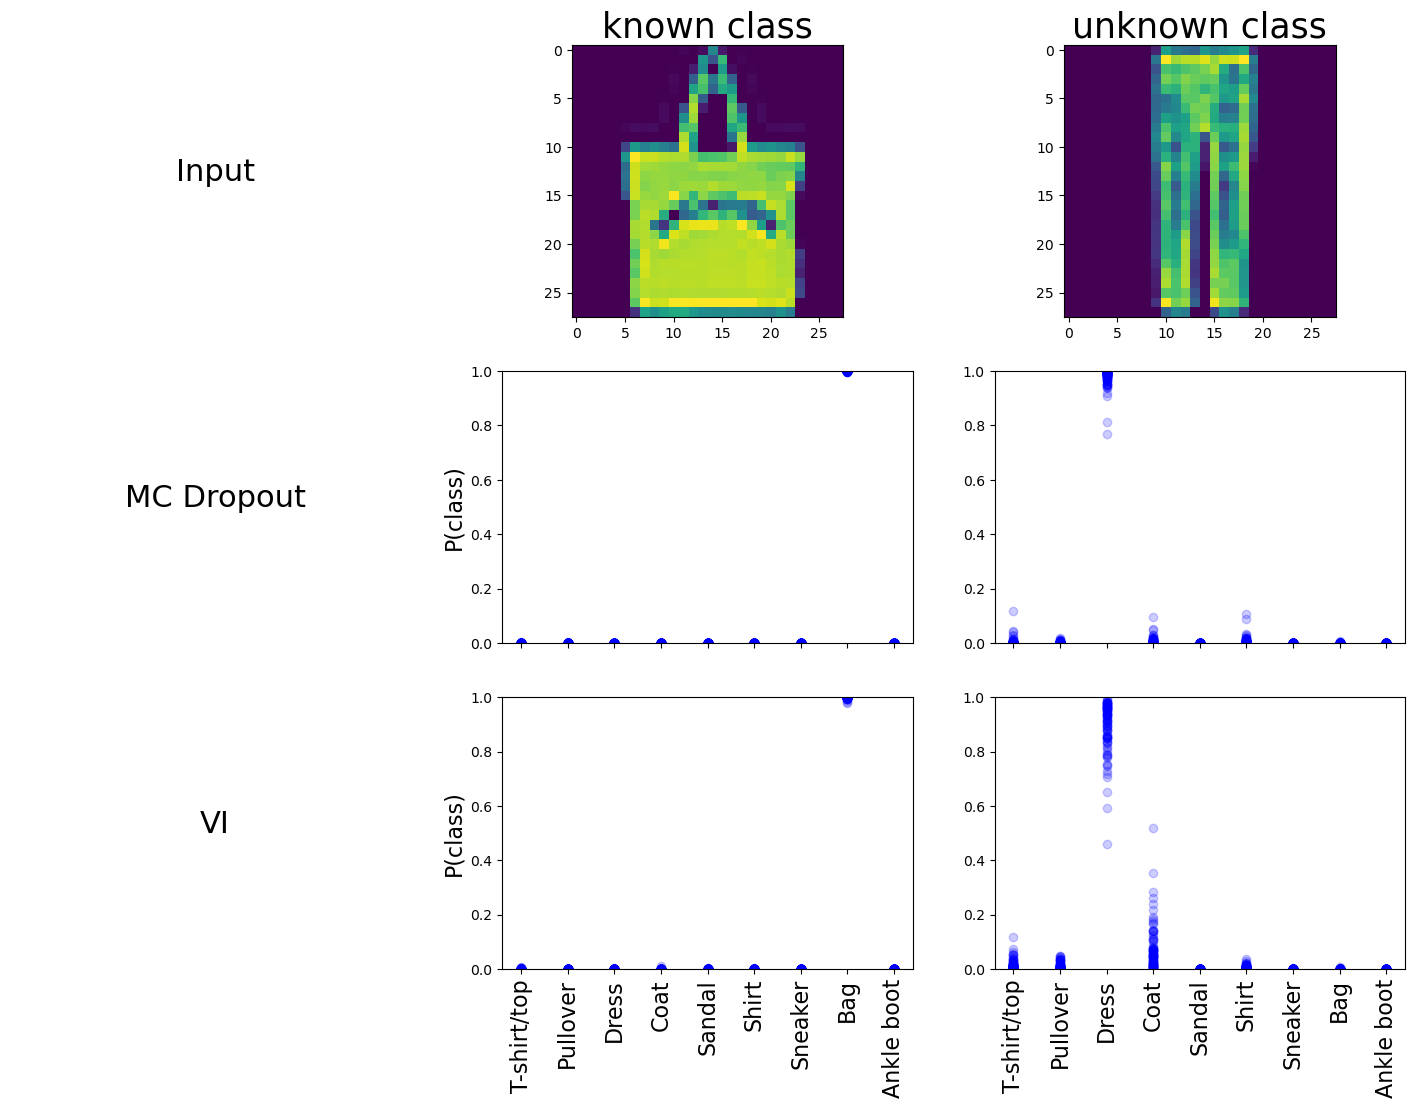

In [90]:
num_samples = 100

plt.figure(figsize=(18,12))
plt.subplot(3,3,1)
plt.axis('off')
plt.text(0.5,0.5, "Input",fontsize=22,horizontalalignment='center')
plt.subplot(3,3,2)
plt.imshow(np.squeeze(np.array(((((X_test_known[random_sample_known])/2)+0.5)*255),dtype="uint8")))
plt.title("known class",fontsize=25)
plt.subplot(3,3,3)
plt.imshow(np.squeeze(np.array(((((X_test_unknown[random_sample_unknown])/2)+0.5)*255),dtype="uint8")))
plt.title("unknown class",fontsize=25)

plt.subplot(3,3,4)
plt.axis('off')
plt.text(0.5,0.5, "MC Dropout",fontsize=22,horizontalalignment='center')
plt.subplot(3,3,5)
for i in range(0, num_samples):
  plt.scatter(range(0,9),model_mc.predict(X_test_known[random_sample_known]),c="blue",alpha=0.2)
plt.xticks(range(0,9),labels=[""]*9,fontsize=16)
plt.xticks(rotation=90)
plt.ylim([0,1])
plt.ylabel("P(class)",fontsize=16)
plt.subplot(3,3,6)
for i in range(0, num_samples):
  plt.scatter(range(0,9),model_mc.predict(X_test_unknown[random_sample_unknown]),c="blue",alpha=0.2)
plt.xticks(range(0,9),labels=[""]*9,fontsize=16)
plt.xticks(rotation=90)
plt.ylim([0,1])

plt.subplot(3,3,7)
plt.axis('off')
plt.text(0.5,0.5, "VI",fontsize=22,horizontalalignment='center')
plt.subplot(3,3,8)
for i in range(0, num_samples):
  plt.scatter(range(0,9),model_vi.predict(X_test_known[random_sample_known]),c="blue",alpha=0.2)
plt.xticks(range(0,9),labels=class_names_known,fontsize=16)
plt.xticks(rotation=90)
plt.ylim([0,1])
plt.ylabel("P(class)",fontsize=16)
plt.subplot(3,3,9)
for i in range(0, num_samples):
  plt.scatter(range(0,9),model_vi.predict(X_test_unknown[random_sample_unknown]),c="blue",alpha=0.2)
plt.xticks(range(0,9),labels=class_names_known,fontsize=16)
plt.xticks(rotation=90)
plt.ylim([0,1])